<a href="https://colab.research.google.com/github/Jeevesh28/BrainDead2k23-Duo-Lipa/blob/main/Problem-2%3A%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. Import the Required Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import keras.backend as K

### **2. Load the Image Training and Validation Datasets**

**i. Get the Image Dataset Paths**

In [ ]:
train_dataset_path = '/kaggle/input/brain-dead-emotion-detection/brain_dead_emotion_detection/Train'
validation_dataset_path = '/kaggle/input/brain-dead-emotion-detection/brain_dead_emotion_detection/Test'

**ii. Load Image Datasets and Apply Augmentations**

In [ ]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

Loading the training dataset and applying augmentations on it

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 1810 images belonging to 4 classes.


Loading the validation dataset

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                              target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                              batch_size=BATCH_SIZE,
                                                              class_mode='categorical',
                                                              shuffle=True)

Found 369 images belonging to 4 classes.


**iii. Get the Label Mappings**

The labels dictionary is made in order to retrive the class names against the label indices used for training the model

In [ ]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : angry
1 : happy
2 : neutral
3 : sad


### **3. Plotting Sample Training Images**

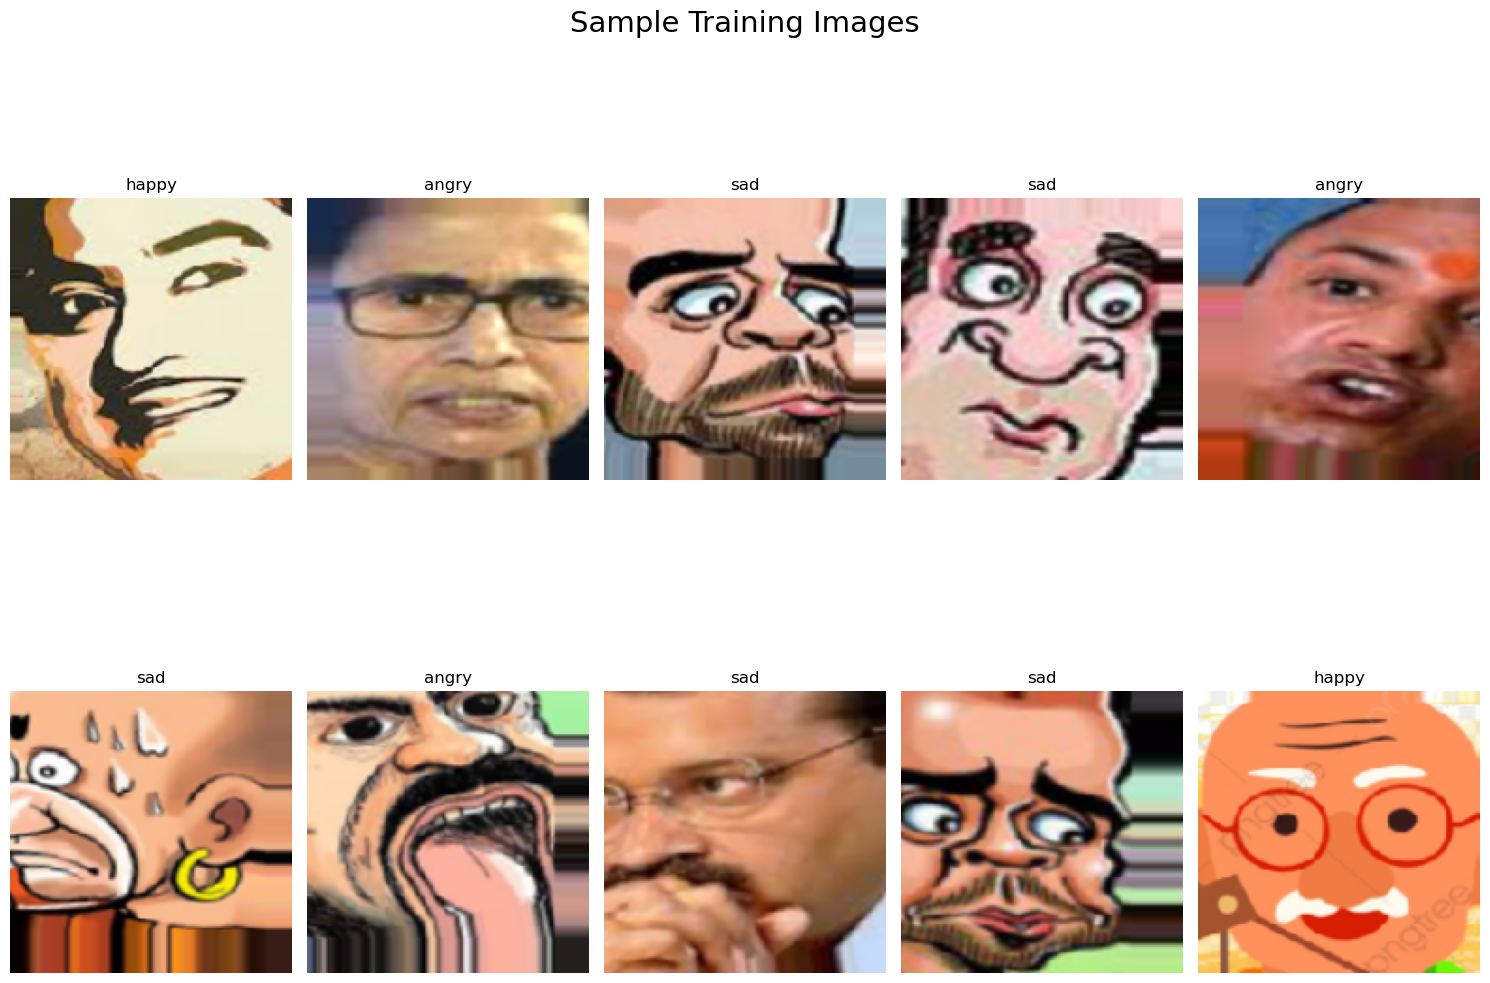

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

### **4. Training a CNN Model**

**i. Create a CNN Model**

In [ ]:
def create_model():
    model = Sequential([
        Conv2D(filters=32, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=64, activation='relu'),
        Dropout(0.2),
        Dense(units=4, activation='softmax')
    ])
    
    return model

In [ ]:
cnn_model = create_model()
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 32)      2432      
                                                                 
 activation (Activation)     (None, 146, 146, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 71, 71, 64)        0

**ii. Defining Callbacks**

**a. Reduce Learning Rate on Plateau:** used to reduce the learning rate when a metric has stopped improving

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

**iii. Defining the Optimizer**

In [ ]:
optimizer = Adam(learning_rate=0.001)

**iv. Loss functions**

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

**v. Compile the Model**

In [ ]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=METRICS)

**vi. Training the Model**

In [ ]:
history = cnn_model.fit(train_generator, epochs=20, validation_data=validation_generator, verbose=1, callbacks=[reduce_lr])

Epoch 1/20
57/57 [==============================] - 62s 1s/step - loss: 2.2718 - accuracy: 0.6927 - precision: 0.3450 - recall: 0.2552 - auc: 0.5868 - f1_score: 0.2932 - val_loss: 1.5716 - val_accuracy: 0.6972 - val_precision: 0.2562 - val_recall: 0.1111 - val_auc: 0.5440 - val_f1_score: 0.1505 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - 59s 1s/step - loss: 1.7155 - accuracy: 0.7149 - precision: 0.3634 - recall: 0.1867 - auc: 0.6098 - f1_score: 0.2464 - val_loss: 1.8571 - val_accuracy: 0.6341 - val_precision: 0.2082 - val_recall: 0.1653 - val_auc: 0.4893 - val_f1_score: 0.1831 - lr: 0.0010
Epoch 3/20
57/57 [==============================] - 59s 1s/step - loss: 1.4935 - accuracy: 0.7311 - precision: 0.4078 - recall: 0.1674 - auc: 0.6448 - f1_score: 0.2329 - val_loss: 1.7608 - val_accuracy: 0.7168 - val_precision: 0.3287 - val_recall: 0.1274 - val_auc: 0.5519 - val_f1_score: 0.1819 - lr: 0.0010
Epoch 4/20
57/57 [==============================] - 55s 964ms/step - loss

### **5. Plotting the Model Metrics**

**i. Plotting training and validation accuracy, loss and learning rate**

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

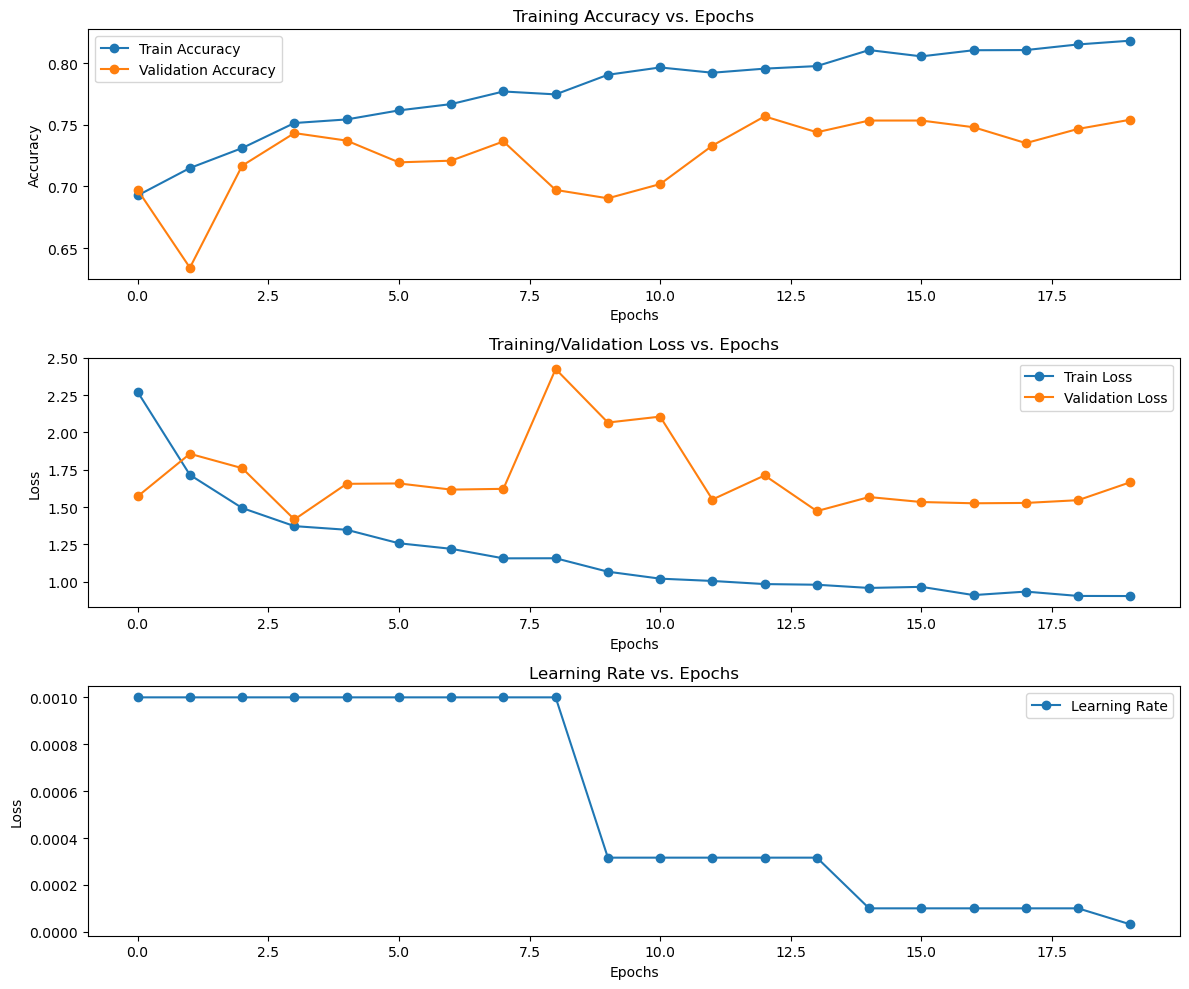

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

### **6. Testing the Model on Test Set**

In [ ]:
test_dataset = '/kaggle/input/brain-dead-emotion-detection/brain_dead_emotion_detection/Test'

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 369 images belonging to 4 classes.


### **7. Model Prediction on the Test Dataset**

In [ ]:
predictions = cnn_model.predict(test_generator)

12/12 [==============================] - 3s 236ms/step


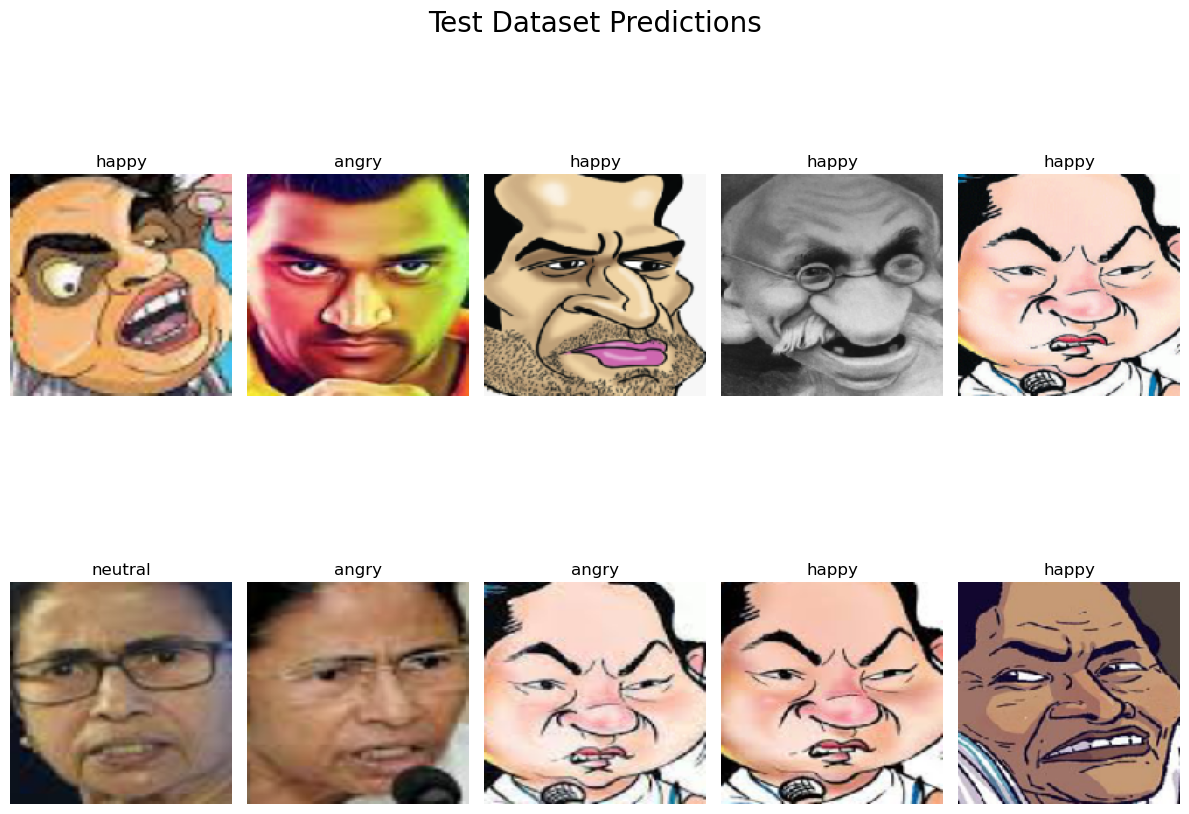

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_auc, test_f1 = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

12/12 [==============================] - 3s 239ms/step - loss: 1.6665 - accuracy: 0.7541 - precision: 0.5119 - recall: 0.3496 - auc: 0.7292 - f1_score: 0.3869


In [ ]:
print(f"Test Loss:      {test_loss}")
print(f"Test Accuracy:  {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall:    {test_recall}")
print(f"Test AUC:       {test_auc}")
print(f"Test F1 score:  {test_f1}")

Test Loss:      1.6664546728134155
Test Accuracy:  0.7540650367736816
Test Precision: 0.511904776096344
Test Recall:    0.34959349036216736
Test AUC:       0.7292224764823914
Test F1 score:  0.38691961765289307


### **8. Plotting the Classification Metrics**

**i. Confusion Matrix**

In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

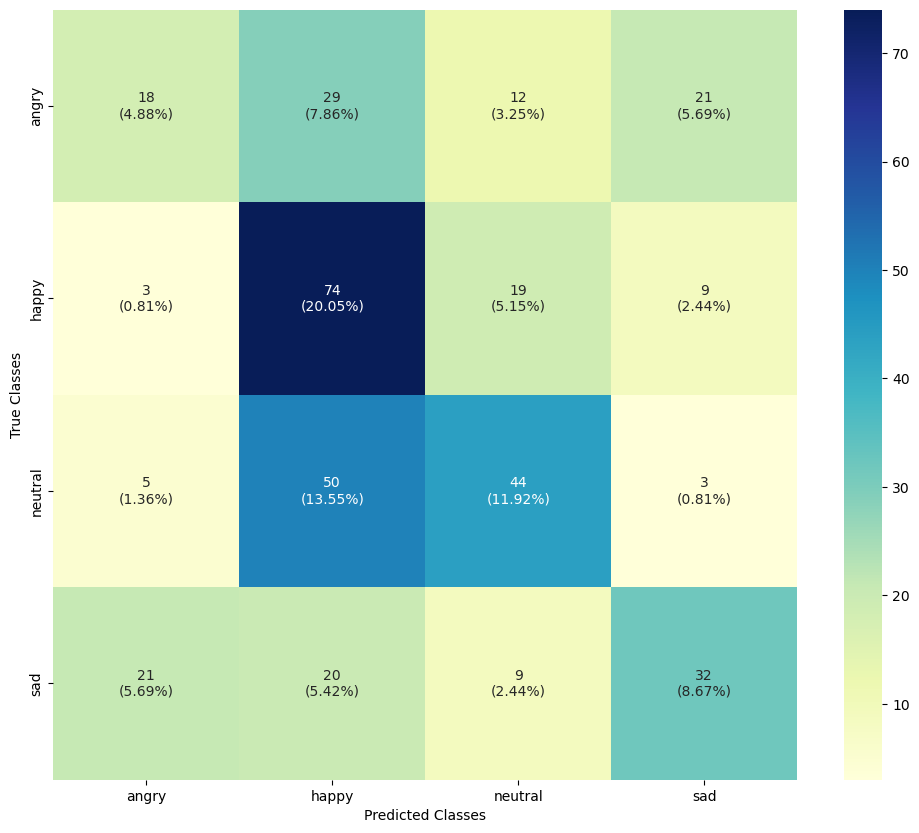

In [ ]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(4, 4)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

**ii. Classification Report**

In [ ]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

       angry       0.38      0.23      0.28        80
       happy       0.43      0.70      0.53       105
     neutral       0.52      0.43      0.47       102
         sad       0.49      0.39      0.44        82

    accuracy                           0.46       369
   macro avg       0.46      0.44      0.43       369
weighted avg       0.46      0.46      0.44       369



### **9. Wrong Predictions**

In [ ]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [ ]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

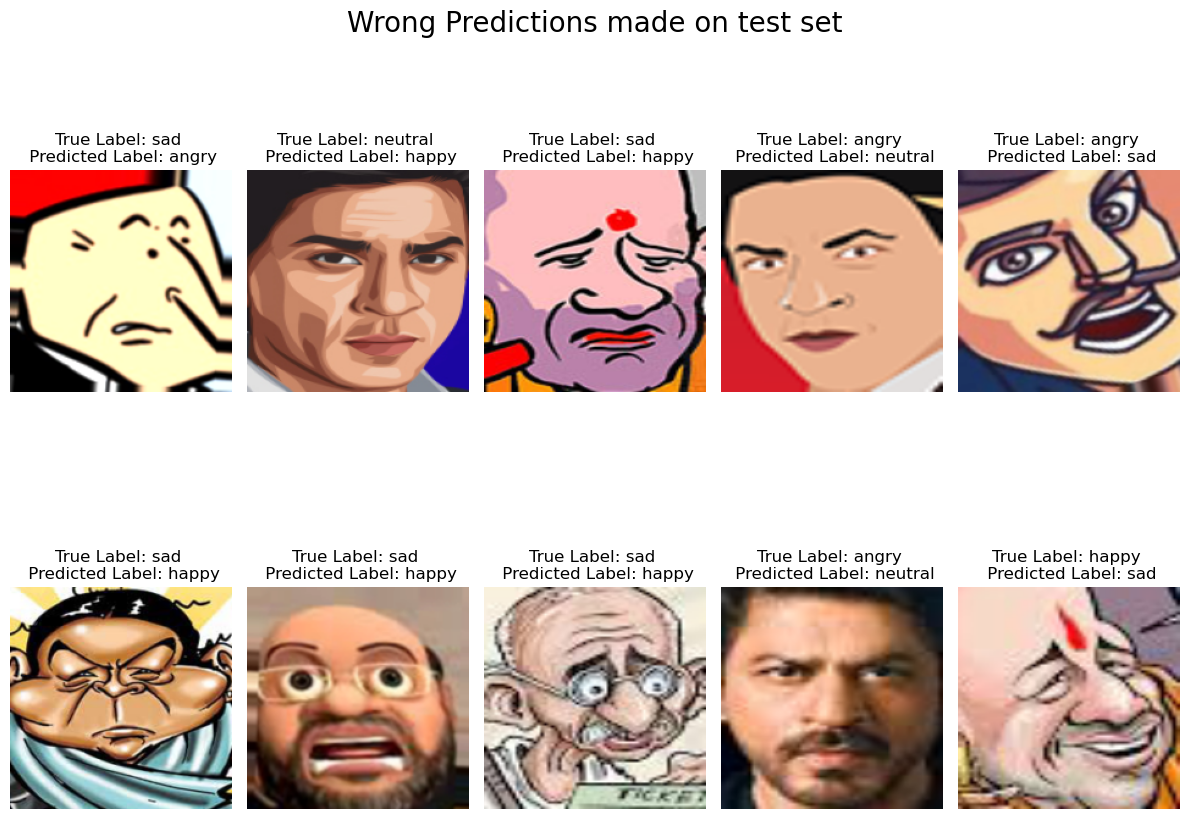

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()